In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
import pickle

import os

from collections import Counter
from scipy.sparse import hstack

from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/IRE_Major_Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
test_data = pd.read_csv(root_path+'dl_test.csv')
train_data = pd.read_csv(root_path+'dl_augmented_train.csv')

In [0]:
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_a,subtask_b,subtask_c,new_tweet_length,original_tweet_length
0,86426,@USER She should ask a few native Americans wh...,ask native americans take be,1,0,0,0,OFF,UNT,NaN,5,14
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home drink maga trump2020,3,2,1,1,OFF,TIN,IND,5,11
2,16820,Amazon is investigating Chinese employees who ...,amazon investigate chinese employees sell inte...,0,5,1,0,NOT,NaN,NaN,19,27
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,OFF,UNT,NaN,6,11
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama want liberals amp illegals move red state,2,0,0,0,NOT,NaN,NaN,8,12


Dropping subtask a and c columns

In [0]:
def parse(data):
  data = data[(data['subtask_b'] == 'TIN') | (data['subtask_b'] == 'UNT')]
  data.drop(columns  = ['subtask_a' , 'subtask_c'] , inplace  = True)
  return data
test_data = parse(test_data)
train_data = parse(train_data)

In [9]:
print(test_data.shape)

(1287, 10)


# Splitting Data: Train and Test


In [11]:
def split_tt(data):
  Y = data['subtask_b']
  X = data.drop(['subtask_b','id'],axis=1)
  print("Shape of X: ",X.shape)
  print("Shape of Y: ",Y.shape)
  return X,Y

X_train, Y_train = split_tt(train_data)
X_test , Y_test =  split_tt(test_data)

Shape of X:  (12449, 8)
Shape of Y:  (12449,)
Shape of X:  (1287, 8)
Shape of Y:  (1287,)


In [0]:
# data['subtask_b'].value_counts()

TIN    3876
UNT     524
Name: subtask_b, dtype: int64

In [0]:
#separating data into train and test
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,stratify=Y, random_state=42)
# print("Shape of X_train: ", X_train.shape)
# print("Shape of Y_train: ",Y_train.shape)
# print("Shape of X_test: ",X_test.shape)
# print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (3080, 8)
Shape of Y_train:  (3080,)
Shape of X_test:  (1320, 8)
Shape of Y_test:  (1320,)


#### Change the mapping of the label column to binary


In [0]:
Y_train = Y_train.map(dict(TIN=0, UNT=1))
Y_test = Y_test.map(dict(TIN=0, UNT=1))

# Making Data Model Ready: Encoding Tweets using GloVe Vectors (Pre-trained)


In [0]:
def get_embedding_matrix(tokenizer,vocab_size):
  '''
  Takes input a tokenizer trained on the training set and vocabulary size
  
  Returns glove vector encoding for each word in the vocabulary (300 dim)
  as embedding_matrix.
  '''

  with open(root_path+'glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

  embedding_matrix = np.zeros((vocab_size, 300))
  cnt=0
  for word, i in tokenizer.word_index.items():
    if word in glove_words:
      embedding_matrix[i] = model[word]
  return embedding_matrix

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['new_tweet'])
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ",vocab_size)

Vocabulary size:  8382


In [0]:
embedding_matrix_train = get_embedding_matrix(tokenizer,vocab_size)

In [17]:
print("Size of embedding matrix to be fed to RNN: ", embedding_matrix_train.shape)

Size of embedding matrix to be fed to RNN:  (8382, 300)


In [0]:
encoded_tweets_train = tokenizer.texts_to_sequences(X_train['new_tweet'])
encoded_tweets_test = tokenizer.texts_to_sequences(X_test['new_tweet'])

In [0]:
padded_tweets_train = pad_sequences(encoded_tweets_train,maxlen=100)
padded_tweets_test = pad_sequences(encoded_tweets_test,maxlen=100)

In [20]:
print("After padding train and test tweets: ")
print("padded train data:",padded_tweets_train.shape)
print("padded test data,", padded_tweets_test.shape)

After padding train and test tweets: 
padded train data: (12449, 100)
padded test data, (1287, 100)


#LSTM


In [30]:
from keras.layers import Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

#def build_model():
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix_train], input_length=100, trainable=False)
#e = Embedding(input_dim = vocab_size, output_dim = 75, input_length=100)
model.add(e)
#model.add(Flatten())
model.add(LSTM(10))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 300)          2514600   
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                12440     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 2,527,051
Trainable params: 12,451
Non-trainable params: 2,514,600
_________________________________________________________________
None


In [32]:
history = model.fit(padded_tweets_train, Y_train.values, epochs=20,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
# fit the model
# model.fit(padded_tweets_train, Y_train.values, epochs=7)
# evaluate the model
loss, accuracy = model.evaluate(padded_tweets_train, Y_train.values)
print('Accuracy: %f' % (accuracy*100))

Train on 11204 samples, validate on 1245 samples
Epoch 1/20
11204/11204 [==============================] - 25s 2ms/step - loss: 0.3868 - acc: 0.8747 - val_loss: 0.3791 - val_acc: 0.8683
Epoch 2/20
11204/11204 [==============================] - 25s 2ms/step - loss: 0.3430 - acc: 0.8776 - val_loss: 0.3935 - val_acc: 0.8683
Epoch 3/20
11204/11204 [==============================] - 25s 2ms/step - loss: 0.3127 - acc: 0.8838 - val_loss: 0.3957 - val_acc: 0.8651
Epoch 4/20
12449/12449 [==============================] - 6s 475us/step
Accuracy: 89.822476


In [0]:
def convert_prob_to_label(p,mean):
  if p >=mean:
    return 1
  return 0

              precision    recall  f1-score   support

           0       0.92      0.68      0.78      1149
           1       0.16      0.52      0.25       138

    accuracy                           0.66      1287
   macro avg       0.54      0.60      0.51      1287
weighted avg       0.84      0.66      0.72      1287



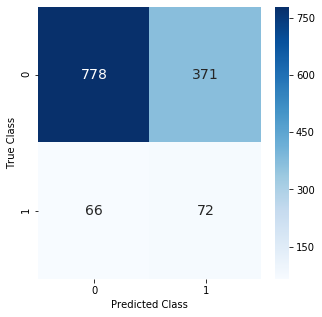

In [34]:
y_pred = model.predict(padded_tweets_test, batch_size=1)
mean1 = np.mean(y_pred)
y_pred_bool = [convert_prob_to_label(p,mean1) for p in y_pred]
print(classification_report(Y_test.values, y_pred_bool))
results = confusion_matrix(Y_test.values, y_pred_bool)
# plt.figure(figsize = (5,5))
# sns.heatmap(results, annot=True,annot_kws={"size": 10}, fmt='g')
# %matplotlib inline
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()
# plt.figure(figsize = (5,5))
# sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')

# sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')

In [35]:
f1_score(Y_test.values, y_pred_bool, average='macro')  

0.5142905504895361

# Analysing Missclassified Tweets


In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_pred_bool)

In [0]:
print(len(misclassified[0]), 'misclassifications')

347 misclassifications


In [0]:
def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk)) 

In [0]:
for index in misclassified[0]:
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_pred_bool[index] == 1:
    prRed(X_test.iloc[index,0])
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_pred_bool[index] == 0:
    prGreen(X_test.iloc[index,0])

 @USER He is way more creepier and says way more stupid things URL
 @USER @USER Bloodsport who can forget the monologue by jackson describing this big monster. and to think he is in his 60's now
 @USER Another overdose nigga:(
 @USER Everyone in Washington including John Heinz is being uncovered as the corrupt elites they are...Like cockroaches running from the light.
 @USER We are “Casually fucked”
 @USER Behold all the conservatives who deliberately ignore the fact that the OK gesture USED TO BE benign but now is co-opted by racists to signal they're down with white supremacy. Much like swastikas were benign in Asian countries (&amp; still are) but were co-opted &amp; ruined by Nazis.
 @USER the owner of my culo
 @USER @USER Because he is a traitor
 @USER @USER Funny how on top of things" you are trying to show you are when its white republicans in the path of the storm. An entire Island was just left to fend for its self for 13 days before help arrived.  Trump is a FAKE PRESIDENT"
 

# BiLSTM

In [0]:
from keras.layers import Input, Bidirectional, LSTM, TimeDistributed

model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix_train], input_length=100, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(32)))
model.add(Dense(16))
model.add(Dropout(0.6))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [0]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          2097300   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                85248     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
activation_4 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)               

In [0]:
# fit the model
model.fit(padded_tweets_train, Y_train.values, epochs=5)
# evaluate the model
loss, accuracy = model.evaluate(padded_tweets_train, Y_train.values)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/5
3080/3080 [==============================] - 15s 5ms/step - loss: 0.4672 - acc: 0.8646
Epoch 2/5
3080/3080 [==============================] - 13s 4ms/step - loss: 0.3914 - acc: 0.8786
Epoch 3/5
3080/3080 [==============================] - 13s 4ms/step - loss: 0.3789 - acc: 0.8808
Epoch 4/5
3080/3080 [==============================] - 13s 4ms/step - loss: 0.3543 - acc: 0.8808
Epoch 5/5
3080/3080 [==============================] - 3s 1ms/step
Accuracy: 88.084416


In [0]:
y_pred = model.predict(padded_tweets_test, batch_size=1)
print(y_pred)

[[0.23922832]
 [0.21811348]
 [0.31854203]
 ...
 [0.0703062 ]
 [0.01681261]
 [0.23777612]]


In [0]:
y_pred_bool = [convert_prob_to_label(p,np.mean(y_pred)) for p in y_pred]
print(y_pred_bool)

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 

              precision    recall  f1-score   support

           0       0.91      0.51      0.65      1163
           1       0.14      0.62      0.23       157

    accuracy                           0.52      1320
   macro avg       0.53      0.56      0.44      1320
weighted avg       0.82      0.52      0.60      1320



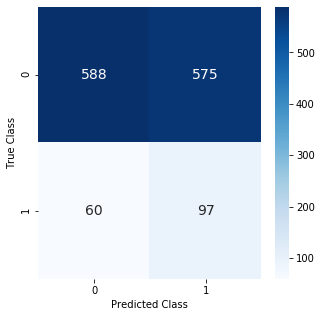

In [0]:
print(classification_report(Y_test.values, y_pred_bool))
results = confusion_matrix(Y_test.values, y_pred_bool)
# plt.figure(figsize = (5,5))
# sns.heatmap(results, annot=True,annot_kws={"size": 10}, fmt='g')
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [0]:
f1_score(Y_test.values, y_pred_bool, average='weighted')  

0.599963739965465